In [16]:
import pandas as pd
from Bio import SeqIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from IPython.display import Image

def parseFasta(data):
    d = {fasta.id : str(fasta.seq) for fasta in SeqIO.parse(data, "fasta")}
    pd.DataFrame([d])

    s = pd.Series(d, name='Sequence')
    s.index.name = 'ID'
    s.reset_index()
    return pd.DataFrame(s)

def kmerXTable(s, a, b):
    tfid_vector = TfidfVectorizer(analyzer='char', ngram_range=(a,b))
    s_hat = tfid_vector.fit_transform(s.Sequence)
    kmerNames = tfid_vector.get_feature_names()
    kmers = s_hat.toarray()
    return pd.DataFrame(kmers,columns=kmerNames, index = s.index)
    
def kmeans(fasta, cNum, klength_min = 6, klength_max = 6, rNum = 50):
    inputData = parseFasta(fasta)
#     temp = virus01.append(inputData)
#     temp = temp.drop_duplicates(keep="last")
        
    inputData["Sequence"] = inputData["Sequence"].apply(lambda x: x.replace("-", ""))
    kmerXTableInput = kmerXTable(inputData, klength_min, klength_max)
        
        
    km = KMeans(random_state = rNum, n_clusters = cNum)
    km.fit(kmerXTableInput) 
    y_hat = km.predict(kmerXTableInput)
        
    return y_hat, kmerXTableInput
        
def kmeans_semiSupervised(fasta, y_hat, klength_min = 6, klength_max = 6, rNum = 50):
    inputData = parseFasta(fasta)
    inputData["Sequence"] = inputData["Sequence"].apply(lambda x: x.replace("-", ""))
    kmerXTableInput = kmerXTable(inputData, klength_min, klength_max)
    
    PCAembedding = PCA(n_components=10)
    NkmerXTableInput = preprocessing.normalize(kmerXTableInput)
    PCAembedding_low = PCAembedding.fit_transform(NkmerXTableInput)
    
    ms = MeanShift()
    ms.fit(PCAembedding_low)
    cluster_centers = ms.cluster_centers_

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        kmms = KMeans(init = cluster_centers, n_clusters = len(cluster_centers))
        kmms_labels = kmms.fit_predict(PCAembedding_low)

    # convert all clusters into two clusters
    kmerXTableInput["pLabels"] = kmms_labels
    kmerXTableInput["aLabels"] = actual_labels = y_hat
    newLabelsClusters = dict()
    unique_actual_labels = get_unique_numbers(kmerXTableInput["aLabels"])
    for actual_label in unique_actual_labels:
        newLabelsClusters[actual_label] = kmerXTableInput[kmerXTableInput["aLabels"] == actual_label]["pLabels"].tolist()

    unique_predicted_labels = get_unique_numbers(kmms_labels)
    new_labels_dict = dict()

    # Map the predicted labels to the given/actual labels
    for plabel in unique_predicted_labels:
        l = {}
        for key in newLabelsClusters.keys():
            if key != -1:
                l[key] = newLabelsClusters[key].count(plabel)
        new_labels_dict[plabel] = max(l, key=l.get)

    # newLabels contains the final results
    newLabels = []
    for i in range(len(kmms_labels)):
        if actual_labels[i] == -1:
            newLabels.append(new_labels_dict[kmms_labels[i]])
        else:
            newLabels.append(actual_labels[i])
            
    return newLabels, kmerXTableInput.drop(columns=["pLabels", "aLabels"])
    
def PCA2d(kTable, y_hat, filename):
    embedding = PCA(n_components= 2)
    nkTable = preprocessing.normalize(kTable)
    embedding.fit(nkTable)
    show = pd.DataFrame(embedding.transform(nkTable))
    # show kmeans clustering
    show["labels"] = y_hat
    ax = show[show["labels"]==1].plot.scatter(x=0, y=1, style="o", color="red", s=2)
    show[show["labels"]==0].plot.scatter(x=0, y=1, style="o", color="blue", s=2, ax=ax)
    show[(show["labels"]!= 0) & (show["labels"]!= 1) ].plot.scatter(x=0, y=1, style="o", color="gray", s=2, ax=ax)
    red = mpatches.Patch(color='red', label='Label 1')
    blue = mpatches.Patch(color='blue', label='Label 0')
    grey = mpatches.Patch(color='grey', label='Label -1')
    plt.legend(handles=[red, blue, grey])
    plt.title('PCA Visualization')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.savefig('nonNotebookFiles/' + filename + '.png', bbox_inches='tight')
    plt.close()
    show.to_csv('nonNotebookFiles/' + filename + "_PCA.csv")
            
def tSNE2d(kTable, y_hat, filename):
    tSNEembedding = TSNE(n_components= 2, random_state = 0)
    tSNEembedding_low = tSNEembedding.fit_transform(kTable)
    show = pd.DataFrame(tSNEembedding_low)
    # show kmeans clustering
    show["labels"] = y_hat
    ax = show[show["labels"]==1].plot.scatter(x=0, y=1, style="o", color="red", s=2)
    show[show["labels"]==0].plot.scatter(x=0, y=1, style="o", color="blue", s=2, ax=ax)
    show[(show["labels"]!= 0) & (show["labels"]!= 1) ].plot.scatter(x=0, y=1, style="o", color="gray", s=2, ax=ax)
    red = mpatches.Patch(color='red', label='Label 1')
    blue = mpatches.Patch(color='blue', label='Label 0')
    grey = mpatches.Patch(color='grey', label='Label -1')
    plt.legend(handles=[red, blue, grey])
    plt.title('tSNE Visualization\n')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.savefig('nonNotebookFiles/' + filename + '.png', bbox_inches='tight')
    plt.close()
    show.to_csv('nonNotebookFiles/' + filename + "_tSNE.csv")

# this method credit to Zhiwen
def get_gene_sequences(filename):
    genes = []
    for record in SeqIO.parse(filename, "fasta"):
        genes.append(str(record.seq))
    return genes

# added helper method for semi-supervised labeling
def get_unique_numbers(numbers):

    list_of_unique_numbers = []

    unique_numbers = set(numbers)

    for number in unique_numbers:
        list_of_unique_numbers.append(number)

    return list_of_unique_numbers

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
#PATH1 = "../data/Sclerotinia_biocontrol_mycovirus_nucleotide.fasta"
#PATH01 = "../data/mycovirus_genbank_all_refseq_nucleotide_unique.fasta"

#virus1 = parseFasta(PATH1)
#virus01 = parseFasta(PATH01)
#virus01 = virus01.append(virus1)
#svirus01 = virus01.drop_duplicates(keep="last")

In [19]:
flu_data = "combined_Bat_Cat_flu.fa"
flu10_labels = pd.read_csv("labels_ten_percent.csv").Labels.tolist()
flu50_labels = pd.read_csv("labels_fifty_percent.csv").Labels.tolist()

flu_only0_labels = pd.read_csv("labels_ten_percent_only0s.csv").Labels.tolist()

flu50_labels

bat_len = len(get_gene_sequences("bat_flu.fa"))

cat_len = len(get_gene_sequences("cat_flu.fa"))

zeros = [0]*bat_len
true_labels = np.append(zeros, [1]*cat_len, axis=None)

In [20]:
y_hat_only0, kmer_only0 = kmeans_semiSupervised(flu_data, flu_only0_labels, 6, 7, 50)

In [21]:
y_hat0, kmer0 = kmeans(flu_data, 2, 6, 7, 50)
y_hat10, kmer10 = kmeans_semiSupervised(flu_data, flu10_labels,  6, 7, 50)
y_hat50, kmer50 = kmeans_semiSupervised(flu_data, flu50_labels, 6, 7, 50)

In [22]:
PCA2d(kmer_only0, flu_only0_labels, "realonly0")
PCA2d(kmer_only0, y_hat_only0, "testonly0")

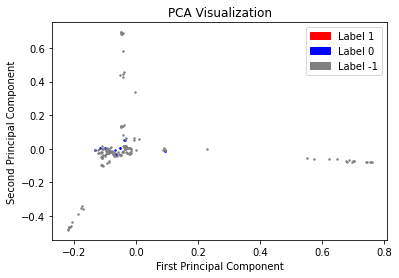

In [23]:
Image("nonNotebookFiles/realonly0.png")

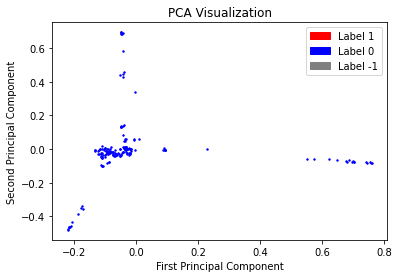

In [24]:
Image("nonNotebookFiles/testonly0.png")

In [25]:
donly0 = {'real10': flu_only0_labels, 'pred10': y_hat_only0}
dfonly20 = pd.DataFrame(data=donly0)

print("Known labels only:")
print(len(dfonly20[(dfonly20['real10'] != -1) & (dfonly20['real10'] == dfonly20['pred10'])])/len(dfonly20[dfonly20['real10'] != -1])*100)
print("\n all labels:")
#print(len(dfonly20[(dfonly20['real10'] == dfonly20['pred10'])])/len(dfonly20['real10'])*100)
print(1 - sum(abs(true_labels - dfonly20['pred10']))/(len(true_labels)))


Known labels only:
100.0

 all labels:
0.3595505617977528


In [26]:
PCA2d(kmer0, y_hat0, "test0")
PCA2d(kmer10, y_hat10, "test10")
PCA2d(kmer50, y_hat50, "test50")

PCA2d(kmer0, flu10_labels, "real10")
PCA2d(kmer0, flu50_labels, "real50")

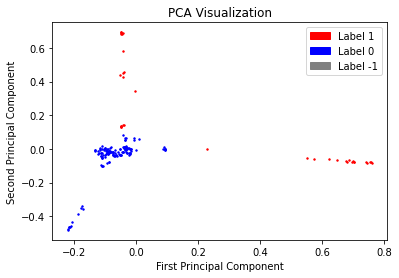

In [27]:
Image("nonNotebookFiles/test0.png")

In [28]:
d10 = {'real10': flu10_labels, 'pred10': y_hat10}
df10 = pd.DataFrame(data=d10)

print("known labels only:")
print(len(df10[(df10['real10'] != -1) & (df10['real10'] == df10['pred10'])])/len(df10[df10['real10'] != -1])*100)

print("\n all labels:")
print(1 - sum(abs(true_labels - df10['pred10']))/(len(true_labels)))


known labels only:
100.0

 all labels:
0.6460674157303371


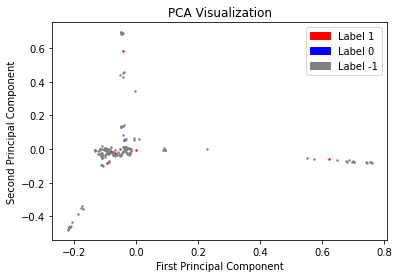

In [29]:
Image("nonNotebookFiles/real10.png")

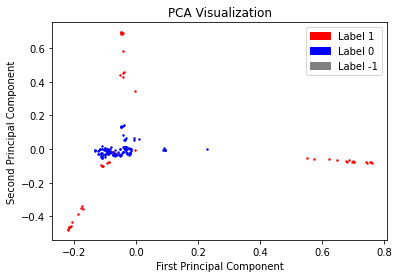

In [30]:
Image("nonNotebookFiles/test10.png")

In [31]:
d50 = {'real50': flu50_labels, 'pred50': y_hat50}
df50 = pd.DataFrame(data=d50)

print("known labels only:")
print(len(df50[(df50['real50'] != -1) & (df50['real50'] == df50['pred50'])])/len(df50[df50['real50'] != -1]) * 100)

print("\n all labels:")
print(1 - sum(abs(true_labels - df50['pred50']))/(len(true_labels)))


known labels only:
100.0

 all labels:
0.7584269662921348


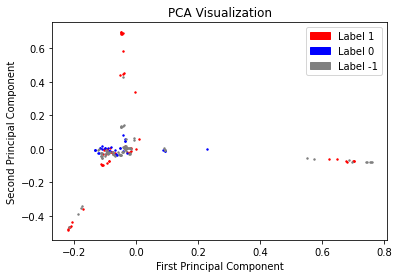

In [32]:
Image("nonNotebookFiles/real50.png")

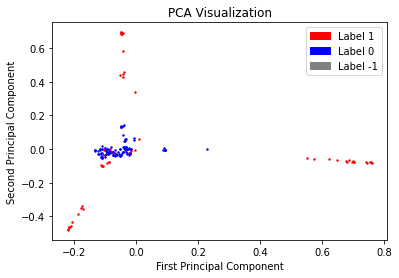

In [33]:
Image("nonNotebookFiles/test50.png")

In [34]:
d0 = {'pred0': y_hat0}
df0 = pd.DataFrame(data=d0)

print("\n all labels:")
print(1 - sum(abs(true_labels - df0['pred0']))/(len(true_labels)))


 all labels:
0.5449438202247191
